In [4]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
import matplotlib.pyplot as plt

def sel_hgrid_indices(field,extent):
    """
    Inputs: 
        field    xarray.dataarray   the existing hgrid lon or lat to be cut down to size
        extent   list               [min,max] the lat OR lon

    Returns:
        numpy array containing the start and end indices needed to slice the hgrid/

    Function finds the indices corresponding to the start and end of some coordinate range such that the hgrid starts and ends with q points rather than t points. Useful for cutting out hgrid automatically. Note that this doesn't work near the poles in the northern hemisphere.
    
    It rounds the input field so that 208.99999999 == 209, giving nice even numbers of points between whole number lat/lon bounds
    
    This function is lazily implemented. Handling the edge cases was easiest to do without vectorising, but there should be numpy functions that would make this less inefficient.
    """
    temp = False

    indices = []

    for i in range(field.shape[0]):
        if round(field[i].values.reshape(1)[0],6) >= extent[0] and temp == False:
            indices.append(2 * i)
            temp = True
        elif round(field[i].values.reshape(1)[0],6) > extent[1] and temp == True:
            indices.append((i-1) * 2 + 1) ## This goes back a step to find the last t point that was in the bounds. Then goes forward one so that the final point to slice is on the corner
            temp = False
            break
    
    return np.array(indices)

om2path = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
    
xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 56.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46579,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 56.00 GiB
Comm: tcp://127.0.0.1:34401,Total threads: 2
Dashboard: /proxy/43051/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37249,


# What this notebook does:

Given a choice of lat / lon coordinates, a hgrid is built from an existing access om2_01 global run. Then, all of the other required input files are interpolated onto this hgrid, and Angus Gibson's 'Brushcutter' creates files for boundary files. It also sets up the mask tables and regrids the runoff, sorting out everything you need to run the experiment.

An input directory is copied into the 'rundir' you choose, and a couple of files are automatically modified based on your experiment. As longs as you don't change your default layout, you

# What's still to do:

* Test whether this setup works for a pan-antarctic style domain. In that case you'd need to set REENTRANT_X = True in MOM_input. Otherwise there might be some other things that need changing to ensure that the input files wrap around properly
* Automate the procedure for changing the resolution. I think this can be done by constructing a new hgrid of whatever resolution, then interpolating everything else onto it as before. Would require reading in a high resolution topography, but otherwise could use the access om2-01 forcing at boundary and initially
* Handle the case where you want to look at a domain that straddles the 'seam' in longitude coordinate at -180.

# Troubleshooting:
* You can get some really weird errors if there are little bays trapped on your boundaries. Try to either avoid this, or fill them in manually if they appear. This is what I was getting: 

"FATAL from PE    56: MOM_regridding: adjust_interface_motion() - implied h<0 is larger than roundoff!"

* If you alter the remapping code, be sure to check that your netcdf files have sensible attributes. You can check yours against a working model by ensuring your attributes match with /scratch/v45/ab8992/mom6/regional_configs/ttide-new/

## Choose your Domain, and set path to your input and run directories

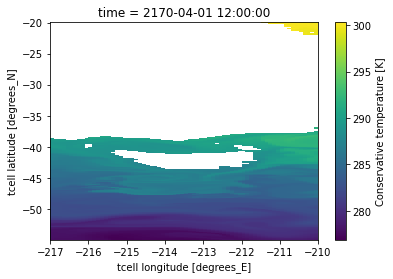

In [37]:

## Choose your coordinates and the name of your experiment
yextent = [-55,-20]
xextent = [-217 , -210]
expt_name = "test"

## Place where all your input files go
path = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}"

for i in [path,rundir]:
    try:
        os.mkdir(i)
    except:
        pass

if "temp" not in os.listdir(path):
    os.mkdir(path + "temp")
if "weights" not in os.listdir(path):
    os.mkdir(path + "weights")
if "forcing" not in os.listdir(path):
    os.mkdir(path + "forcing")


full_domain = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc")

# domain.tau_x.sel(yu_ocean=slice(-49, -5), xu_ocean=slice(-217, -183)).isel(time = 0).plot()
domain = full_domain.surface_temp.sel(yt_ocean=slice(yextent[0], yextent[1]), xt_ocean=slice(xextent[0],xextent[1])).isel(time = 0)
fig,ax = plt.subplots(1,figsize = (10,10))

domain.plot(ax = ax)
ax.set_title(f"{expt_name} domain")

# Step by step procedure to set up experiment

## 1. Find the indices of the hgrid that we need based on the lat/lon chosen above

In [38]:
hgrid = xr.open_dataset(om2path + "ocean_hgrid.nc")

x_indices_hgrid = sel_hgrid_indices(hgrid.x.isel(nyp = 1000,nxp = slice(0,None,2)),xextent)  ## As long as it's away from the north pole things are ok since lon doesn't vary with lat
y_indices_hgrid = sel_hgrid_indices(hgrid.y.isel(nxp = 0,nyp = slice(0,None,2)),yextent) 

encoding = {'x': {'_FillValue': None},
            'y': {'_FillValue': None},
            "dx": {"_FillValue": None},
            'dy': {'_FillValue': None},
            'angle_dx': {'_FillValue': None},
            'area': {'_FillValue': None}
            }  

hgrid_new = hgrid.isel(
    nyp = slice(y_indices_hgrid[0] , y_indices_hgrid[1] ),
    nxp = slice(x_indices_hgrid[0] , x_indices_hgrid[1] ),
    ny = slice(y_indices_hgrid[0] , y_indices_hgrid[1] - 1 ),
    nx = slice(x_indices_hgrid[0] , x_indices_hgrid[1] - 1 ))

hgrid_new.to_netcdf(path + "hgrid.nc",mode = "w",encoding = encoding)

## 2. Cut out the initial condition velocities and interpolate onto the cgrid

Here we can use the normal xarray select tool to get the initial velocities. This is set by default to be at time=30, as this is how Angus set things up. 

The horizontal coordinates are a bit of a mess. Initially, the mom5 data uses xu_ocean,xt_ocean etc. In MOM6, yh,xq etc are used. Here, they're renamed to "lat/lon" for the regridder. Afterwards, the velocities are named in the "xh,yq" convention, but the tracers aren't. This is to be consistent with Angus' example EAC configuration. I suspect there would be no issue renaming the coordinates consistently if the relevent MOM files were altered to match. 

Note also that the "encoding" parameters are needed to overwrite xarray's default values. xr will put in its own NaNs as the _FillVallue which aren't compatible with MOM6

In [18]:
## pull out the initial velocity on MOM5's Bgrid
u_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_u.nc").u.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)
v_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_v.nc").v.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)

## Pull out the surface height, temp and salinity initial conds
temperature = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_temp.nc").temp.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))  - 273.15## Convert to Celcius for MOM6!
salt = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_salt.nc").salt.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))

## Merge tracer ICs together
init_cond = xr.merge([temperature,salt]).drop_vars("time").rename({"xt_ocean": "lon", "yt_ocean": "lat"})

init_eta = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc").isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1])).rename({"xt_ocean": "lon", "yt_ocean": "lat"})


## Construct the xq,yh and xh yq grids
ugrid = hgrid_new[["x","y"]].isel(nxp=slice(None, None, 2), nyp=slice(1, None, 2)).rename({"x": "lon", "y": "lat"})
vgrid = hgrid_new[["x","y"]].isel(nxp=slice(1, None, 2), nyp=slice(None, None, 2)).rename({"x": "lon", "y": "lat"})

## Construct the cell centre grid for tracers (xh,yh). 
tgrid = xr.Dataset(
    {"lon":(["lon"],hgrid_new.x.isel(nxp=slice(1, None, 2), nyp=1).values),
     "lat":(["lat"],hgrid_new.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
            }
)


regridder_u = xe.Regridder(
    u_init_bgrid, ugrid, "bilinear",
)
regridder_v = xe.Regridder(
    v_init_bgrid, vgrid, "bilinear",
)

regridder_t = xe.Regridder(
    init_cond, tgrid, "bilinear",
)

u_on_c = regridder_u(u_init_bgrid)

print(u_on_c.coords)

u_on_c = u_on_c.rename({"lon": "xq", "lat": "yh", "nyp": "ny"})
print(u_on_c.coords)

u_on_c.name = "u"
## Give attributes back
u_on_c.attrs = u_init_bgrid.attrs 
u_on_c.xq.attrs = u_init_bgrid.lon.attrs
u_on_c.yh.attrs = u_init_bgrid.lat.attrs
u_on_c.st_ocean.attrs = u_init_bgrid.st_ocean.attrs

v_on_c = regridder_v(v_init_bgrid)
v_on_c = v_on_c.rename({"lon": "xh", "lat": "yq", "nxp": "nx"})
v_on_c.name = "v"
## Give attributes back
v_on_c.attrs = v_init_bgrid.attrs 
v_on_c.xh.attrs = v_init_bgrid.lon.attrs
v_on_c.yq.attrs = v_init_bgrid.lat.attrs
v_on_c.st_ocean.attrs = v_init_bgrid.st_ocean.attrs

vel_init_cgrid = xr.merge((u_on_c, v_on_c),)
vel_init_cgrid.st_ocean.attrs["axis"] = "Z"

vel_init_cgrid.fillna(0).drop_vars("time").to_netcdf(
    path + "forcing/init_vel_cgrid.nc",
    mode = "w",
    encoding={
        "u": {"_FillValue": netCDF4.default_fillvals["f4"]},
        "v": {"_FillValue": netCDF4.default_fillvals["f4"]}        
    },
)


## regrid tracers
init_cond_rg = regridder_t(init_cond)
init_cond_rg = init_cond_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
## Give attributes back
init_cond_rg.attrs = init_cond.attrs 
init_cond_rg.xt_ocean.attrs = init_cond.lon.attrs
init_cond_rg.yt_ocean.attrs = init_cond.lat.attrs
init_cond_rg.st_ocean.attrs = init_cond.st_ocean.attrs

init_cond_rg.to_netcdf(
    path + "forcing/init_cond.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                "st_ocean": {"_FillValue": None},
                'temp': {'_FillValue': -1e20,'missing_value': -1e20},
                'salt': {'_FillValue': -1e20,'missing_value': -1e20}
                },
)


## regrid eta
init_eta_rg = regridder_t(init_eta.eta_t)
init_eta_rg = init_eta_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})

## Give attributes back
init_eta_rg.attrs = init_eta.attrs 
init_eta_rg.xt_ocean.attrs = init_eta.lon.attrs
init_eta_rg.yt_ocean.attrs = init_eta.lat.attrs

init_eta_rg.name = "eta_t"

init_eta_rg.drop_vars("time").to_netcdf(
    path + "forcing/init_eta.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                'eta_t':{'_FillValue':None}
                },
)





/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 2170-05-01 12:00:00
    lon       (nyp, nxp) float64 -217.0 -216.9 -216.8 ... -215.2 -215.1 -215.0
    lat       (nyp, nxp) float64 -54.95 -54.95 -54.95 ... -53.07 -53.07 -53.07
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 2170-05-01 12:00:00
    xq        (ny, nxp) float64 -217.0 -216.9 -216.8 ... -215.2 -215.1 -215.0
    yh        (ny, nxp) float64 -54.95 -54.95 -54.95 ... -53.07 -53.07 -53.07


In [52]:
tgrid = xr.Dataset(
    {"lon":(["lon"],hgrid_new.x.isel(nxp=slice(1, None, 2), nyp=1).values),
     "lat":(["lat"],hgrid_new.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
            }
)


## 3 Get the topography, and cut out using the indices from hgrid

For now, this step assumes that we're just cutting the hgrid and topo from the same mom5 experiment. This means that the indices for cutting out the hgrid can be used to cut out the topo and runoff. If resolution changes, hgrid and topo will generated in some other way. Could also interpolate a topography file the same way as initial conditions above

In [39]:
topog = xr.open_dataset("/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/topog.nc").rename({"xx":"nx","yy":"ny"})
topog = topog.expand_dims({'ntiles':1})

x_indices_centre = x_indices_hgrid //2    ## To go from the hgrid's indices (which refer to cell edges) to cell centres, we just need to //2. 
y_indices_centre = y_indices_hgrid //2    ## For cell corners, we'd need to go hgrid //2 for start of slice, //2 + 1 for end of slice

encoding = {"depth":{'_FillValue': None}} 


topog.isel(nx = slice(x_indices_centre[0],x_indices_centre[1]) , ny = slice(y_indices_centre[0],y_indices_centre[1])).to_netcdf(path + "topog.nc",mode = "w",encoding = encoding)



## 4. Use the c executables from mom5 tools to construct the mosaic and mask tables

# Make ocean mosaic

This requires running some "mom5 tools" scripts via subprocess

In [40]:

args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args,cwd = path),sep = "\n")

args = "--input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc".split(" ")

print("QUICK MOSAIC" , subprocess.run([toolpath + "make_quick_mosaic/make_quick_mosaic"] + args,cwd = path),sep = "\n")

args = "--grid_file ocean_mosaic.nc --ocean_topog topog.nc --layout 10,10 --halo 4".split(" ")

print("CHECK MASK" , subprocess.run([toolpath + "check_mask/check_mask"] + args,cwd = path))

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)

# Prepare boundary segments

In [23]:
t = range(1077, 1082) # original
# t = range(1077, 1079)
base = os.getenv("PBS_JOBFS")

surface_tracer_vars = ["temp", "salt"]
line_tracer_vars = ["eta_t"]
surface_velocity_vars = ["u", "v"]
surface_vars = surface_tracer_vars + surface_velocity_vars

chunks = {
    "T": {"time": 1, "st_ocean": 7, "yt_ocean": 300, "xt_ocean": None},
    "U": {"time": 1, "st_ocean": 7, "yu_ocean": 300, "xu_ocean": None},
}

def time_rotate(d):
    left = d.sel(time=slice("2171-01-01", None))
    left["time"] = pd.date_range("1991-01-01 12:00:00", periods=120)

    right = d.sel(time=slice(None, "2170-12-31"))
    right["time"] = pd.date_range("1991-05-01 12:00:00", periods=245)

    return xr.concat([left, right], "time")

in_datasets = {}
for var, staggering in list(zip(surface_tracer_vars, cycle("T"))) + list(
    zip(surface_velocity_vars, cycle("U"))
):
    d = xr.open_mfdataset(
        [
            f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{i}/ocean/ocean_daily_3d_{var}.nc"
            for i in t
        ],
        chunks=chunks[staggering],
        combine="by_coords",
        parallel=False,
    )[var]
    in_datasets[var] = staggering, d

# line datasets, assume they all come from ocean_daily
d_2d = xr.open_mfdataset(
    [
        f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{i}/ocean/ocean_daily.nc"
        for i in t
    ],
    chunks={"time": 1, "yt_ocean": 300, "xt_ocean": None},
    combine="by_coords",
    parallel=False,
)[line_tracer_vars]

d_tracer = xr.merge([d for s, d in in_datasets.values() if s == "T"] + [d_2d])
d_velocity = xr.merge([d for s, d in in_datasets.values() if s == "U"])

# time slicing

d_tracer = time_rotate(d_tracer.sel(time=slice("2170-05-01", "2171-04-30")))
d_velocity = time_rotate(d_velocity.sel(time=slice("2170-05-01", "2171-04-30")))

# reduce selection around target latitude
# and remove spatial chunks (required for xesmf)
d_tracer = d_tracer.sel(yt_ocean=slice(yextent[0] - 1, yextent[1] + 1), xt_ocean=slice(xextent[0] - 1,xextent[1] + 1)).chunk(
    {"yt_ocean": None, "xt_ocean": None}
)
d_velocity = d_velocity.sel(yu_ocean=slice(yextent[0] - 1, yextent[1] + 1), xu_ocean=slice(xextent[0] - 1,xextent[1] + 1)).chunk(
    {"yu_ocean": None, "xu_ocean": None}
)

with ProgressBar():
    d_tracer.to_zarr(
        f"{base}/tracer.zarr",
        encoding={"time": {"dtype": "double", "units": "days since 1900-01-01 12:00:00", "calendar": "noleap"}},
        mode = "w"
    )

with ProgressBar():
    d_velocity.to_zarr(
        f"{base}/velocity.zarr",
        encoding={"time": {"dtype": "double", "units": "days since 1900-01-01 12:00:00", "calendar": "noleap"}},
        mode = "w"
    )
    
## If you get some error about path containing a group it's because the zarr files already exist. Delete them

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/process.py", line 175, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/nanny.py", line 918, in _run
    loop.run_sync(do_stop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, i

# Brushcut

In [ ]:
surface_tracer_vars = ["temp", "salt"]
line_tracer_vars = ["eta_t"]
surface_velocity_vars = ["u", "v"]
surface_vars = surface_tracer_vars + surface_velocity_vars



def input_datasets():
    # open target grid dataset
    # we interpolate onto the hgrid
    dg = xr.open_dataset(path + "hgrid.nc")

    d_tracer = xr.open_zarr(f"{os.getenv('PBS_JOBFS')}/tracer.zarr")
    d_velocity = xr.open_zarr(f"{os.getenv('PBS_JOBFS')}/velocity.zarr")

    return dg, d_tracer, d_velocity

def interp_segment(segment):
    dg, d_tracer, d_velocity = input_datasets()
    i, edge = segment

    dg_segment = dg.isel(**edge)
    # interpolation grid
    dg_out = xr.Dataset(
        {
            "lat": (["location"], dg_segment.y.squeeze().data),
            "lon": (["location"], dg_segment.x.squeeze().data),
        }
    )

    # segment suffix
    seg = f"segment_{i+1:03}"
    seg_dir = ["nx", "nx", "ny", "ny"][i]
    seg_alt = ["ny", "ny", "nx", "nx"][i]
    alt_axis = [2, 2, 3, 3][i]

    # create the regridding weights between our grids
    # note: reuse_weights should be False unless the weights files
    #       do indeed exist!
    regridder_tracer = xe.Regridder(
        d_tracer.rename(xt_ocean="lon", yt_ocean="lat"),
        dg_out,
        "bilinear",
        locstream_out=True,
        reuse_weights=False,
        filename= path + f"weights/bilinear_tracer_weights_{seg}.nc",
    )
    regridder_velocity = xe.Regridder(
        d_velocity.rename(xu_ocean="lon", yu_ocean="lat"),
        dg_out,
        "bilinear",
        locstream_out=True,
        reuse_weights=False,
        filename=path + f"weights/bilinear_velocity_weights_{seg}.nc",
    )

    # now we can apply it to input DataArrays:
    segment_out = xr.merge([regridder_tracer(d_tracer), regridder_velocity(d_velocity)])
    del segment_out["lon"]
    del segment_out["lat"]
    segment_out["temp"] -= 273.15

    # fill in NaNs
    segment_out = (
        segment_out
        .ffill("st_ocean")
        .interpolate_na("location")
        .ffill("location")
        .bfill("location")
    )

    # fix up all the coordinate metadata
    segment_out = segment_out.rename(location=f"{seg_dir}_{seg}")
    for var in surface_vars:
        segment_out[var] = segment_out[var].rename(st_ocean=f"nz_{seg}_{var}")
        segment_out = segment_out.rename({var: f"{var}_{seg}"})
        segment_out[f"nz_{seg}_{var}"] = np.arange(segment_out[f"nz_{seg}_{var}"].size)

    for var in line_tracer_vars:
        segment_out = segment_out.rename({var: f"{var}_{seg}"})

    # segment coordinates (x, y, z)
    segment_out[f"{seg_dir}_{seg}"] = np.arange(segment_out[f"{seg_dir}_{seg}"].size)
    segment_out[f"{seg_alt}_{seg}"] = [0]

    # lat/lon/depth/dz
    segment_out[f"lon_{seg}"] = ([f"ny_{seg}", f"nx_{seg}"], dg_segment.x.data)
    segment_out[f"lat_{seg}"] = ([f"ny_{seg}", f"nx_{seg}"], dg_segment.y.data)

    # reset st_ocean so it's not an index coordinate
    segment_out = segment_out.reset_index("st_ocean").reset_coords("st_ocean_")
    depth = segment_out["st_ocean_"]
    depth.name = "depth"
    depth["st_ocean"] = np.arange(depth["st_ocean"].size)
    del segment_out["st_ocean_"]

    # some fiddling to do dz in the same way as brushcutter, while making xarray happy
    dz = depth.diff("st_ocean")
    dz.name = "dz"
    dz = xr.concat([dz, dz[-1]], dim="st_ocean")
    dz["st_ocean"] = depth["st_ocean"]

    encoding_dict = {
        "time": {
            "dtype": "double",
            "units": "days since 1900-01-01 12:00:00",
            "calendar": "noleap",
        },
        f"nx_{seg}": {
            "dtype": "int32",
        },
        f"ny_{seg}": {
            "dtype": "int32",
        },
    }

    for var in line_tracer_vars:
        v = f"{var}_{seg}"

        segment_out[v] = segment_out[v].expand_dims(
            f"{seg_alt}_{seg}", axis=alt_axis - 1
        )

        encoding_dict[v] = {
            "_FillValue": netCDF4.default_fillvals["f8"],
        }

    for var in surface_vars:
        v = f"{var}_{seg}"

        # add the y dimension
        segment_out[v] = segment_out[v].expand_dims(
            f"{seg_alt}_{seg}", axis=alt_axis
        )
        segment_out[f"dz_{v}"] = (
            ["time", f"nz_{v}", f"ny_{seg}", f"nx_{seg}"],
            da.broadcast_to(
                dz.data[None, :, None, None],
                segment_out[v].shape,
                chunks=(1, None, None, None),
            ),
        )

        s = list(segment_out[v].shape)
        s[0] = 1 # chunked in time
        s[1] = 11 # a little bit of vertical chunking

        encoding_dict[v] = {
            "_FillValue": netCDF4.default_fillvals["f8"],
            "zlib": True,
            "chunksizes": tuple(s),
        }
        encoding_dict[f"dz_{v}"] = {
            "_FillValue": netCDF4.default_fillvals["f8"],
            "zlib": True,
            "chunksizes": tuple(s),
        }
        encoding_dict[f"nz_{seg}_{var}"] = {
            "dtype": "int32"
        }

    with ProgressBar():
        segment_out["time"] = segment_out["time"].assign_attrs({"modulo":" "}) ## Add modulo attribute for MOM6 to treat as repeat forcing
        segment_out.load().to_netcdf(path + f"forcing/forcing_obc_{seg}.nc", encoding=encoding_dict, unlimited_dims="time")



for seg in enumerate([{"nyp": [0]}, {"nyp": [-1]}, {"nxp": [0]}, {"nxp": [-1]}]):
    interp_segment(seg)

2022-09-15 17:39:30,988 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:30,991 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:31,033 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:31,079 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:31,161 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:31,206 - distributed.nanny - WARNING - Restarting worker
2022-09-15 17:39:31,243 - distributed.nanny - WARNING - Restarting worker


# Regrid Runoff

In [44]:
## Cut runoff from JRA input

JRA = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc"

jra_runoff = xr.open_dataset(JRA).sel(latitude = slice(yextent[0],yextent[1]),
         longitude = slice(xextent[0] + 360,xextent[1] + 360) ## need to add 360 since xextent is between -280 -> 80
        ) 
# jra_runoff = xr.open_dataset(JRA)

## Angus' code for runoff regrid below

In [45]:
# ocean mask and supergrid (reduced to tracer points) for the target grid
dm = xr.open_dataset(path + "ocean_mask.nc").rename({"nx": "longitude", "ny": "latitude"})
dg = (
    xr.open_dataset(path + "hgrid.nc")
    .isel(nxp=slice(1, None, 2), nyp=slice(1, None, 2))
    .rename({"nyp": "latitude", "nxp": "longitude"})
)

# merge areas to get full cell area
area = dg.area
area["ny"] = area.ny // 2
area["nx"] = area.nx // 2
area = (
    area
    .stack(cell=["ny", "nx"])
    .groupby("cell")
    .sum()
    .unstack("cell")
)

# calculate coastal mask
cst = xr.zeros_like(dm.mask)
for dim in ["longitude", "latitude"]:
    for off in [-1, 1]:
        cst = xr.where((dm.mask > 0) & (dm.mask.shift(**{dim: off}) == 0), 1, cst)

# indices of coast points -- Nx2, first column are y indices, then x indices
cst_pts = np.vstack(np.nonzero(cst)).T
# coords of coast points -- Nx2, first column are latitudes, then longitudes
cst_coords = xr.concat((dg.y, dg.x + 360), "d").data.reshape(2, -1).T[np.flatnonzero(cst)]
cst_areas = area.data.flatten()[np.flatnonzero(cst)]

kd = KDTree(cst_coords)

# open the runoff section and construct its corner points
# dr = xr.open_dataset("runoff_box.nc")
dr = jra_runoff
res = 0.25
lons = np.arange(dr.longitude[0] - res/2, dr.longitude[-1] + res, res)
lats = np.arange(dr.latitude[0] - res/2,  dr.latitude[-1] + res, res)

# source coords for remapping
runoff_coords = np.c_[np.meshgrid(dr.latitude, dr.longitude, indexing="ij")].reshape(2, -1).T
# coords for cell area calculation
corner_lat, corner_lon = np.meshgrid(np.deg2rad(lats), np.deg2rad(lons), indexing="ij")
Re = 6378.137e3
runoff_areas = np.abs(
    ((corner_lon[1:,1:] - corner_lon[:-1,:-1]) * Re**2) * (np.sin(corner_lat[1:,1:]) - np.sin(corner_lat[:-1,:-1]))
)

# nearest coastal point for every runoff point
_, nearest_cst = kd.query(runoff_coords)

# create output DataArray
runoff = xr.DataArray(
    0.0,
    {"time": dr.time, "latitude": dg.y.isel(longitude=0), "longitude": dg.x.isel(latitude=0)},
    ["time", "latitude", "longitude"]
)
runoff.name = "friver"
runoff.time.attrs["modulo"] = " "

ind_y = xr.DataArray(cst_pts[:,0], dims="coast")
ind_x = xr.DataArray(cst_pts[:,1], dims="coast")

for i in range(dr.time.size):
    # list of nearest coast point (on target grid), with the source data
    dat = np.c_[nearest_cst, (dr.friver[i].data * runoff_areas).flatten()]
    dat = dat[dat[:,0].argsort()] # sort by coast point idx

    # group by destination point
    cst_point, split_idx = np.unique(dat[:,0], return_index=True)
    cst_point = cst_point.astype(int)
    split_idx = split_idx[1:]

    # sum per destination point
    dat_cst = [x.sum() for x in np.split(dat[:,1], split_idx)]

    # assign the target value
    runoff[i, ind_y[cst_point], ind_x[cst_point]] = dat_cst / cst_areas[cst_point]

runoff.to_netcdf(path + "runoff_regrid.nc", unlimited_dims="time")


# Set up files in run directory

NIGLOBAL = 80

NJGLOBAL = 129

In [43]:
subprocess.run(f"cp defaults/* {rundir}",shell = True)
subprocess.run(f"ln -s {path} {rundir}/inputdir",shell=True)

## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{path}"):
    if "mask_table" in i:
        mask_table = i
    a = mask_table.split(".")[1]
    b = mask_table.split(".")[2].split("x")
    ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table
    if "NIGLOBAL" in lines[i]:
        lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        
    if "NJGLOBAL" in lines[i]:
        lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        
    if "NJGLOBAL" in lines[i]:
        lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: "{str(ncpus)}"\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {path}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

CompletedProcess(args='ln -s /scratch/v45/ab8992/mom6/regional_configs/ttide-new/ /home/149/ab8992/mom6_rundirs/ttide-new/inputdir', returncode=0)

In [48]:
print(f"ln -s {path} {rundir}/inputdir")

ln -s /scratch/v45/ab8992/mom6/regional_configs/ttide-new/ /home/149/ab8992/mom6_rundirs/ttide-new/inputdir


## Other things that could be automated:
1. Change mask table name automatically X
2. Change ncpus to match mask table
3. Change name of run
4. Point to correct working directory in config.yaml
5. Put in the vcoord. Currently copying from Angus


## Some errors I ran into:


# Read in to debug

In [13]:
init_vel = xr.open_dataset(path + "forcing/init_vel_cgrid.nc")
land_mask = xr.open_dataset(path + "land_mask.nc")
topog = xr.open_dataset(path + "topog.nc")
init_eta = xr.open_dataset(path + "forcing/init_eta.nc")

eacpath = "/g/data/x77/ahg157/inputs/mom6/eac-01/"

eac_init_vel = xr.open_dataset(eacpath + "forcing/init_vel_cgrid.nc")
eac_init_eta = xr.open_dataset(eacpath + "forcing/init_eta.nc")

eac_land_mask = xr.open_dataset(eacpath + "land_mask.nc")


